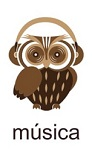

# ETL Processes
Use this notebook to develop the ETL process for each of your tables before completing the `etl.py` file to load the whole datasets.

In [1]:
import os
import glob
import psycopg2
import pandas as pd
from sql_queries import *



import numpy as np
from psycopg2.extensions import register_adapter, AsIs
psycopg2.extensions.register_adapter(np.int64, psycopg2._psycopg.AsIs)

In [2]:
conn = psycopg2.connect("host=127.0.0.1 dbname=musicadb user=postgres password=yashmoyal")
cur = conn.cursor()

In [3]:
def get_files(filepath):
    all_files = []
    for root, dirs, files in os.walk(filepath):
        files = glob.glob(os.path.join(root,'*.json'))
        for f in files :
            all_files.append(os.path.abspath(f))
    
    return all_files

# Process `song_data`
In this first part, you'll perform ETL on the first dataset, `song_data`, to create the `songs` and `artists` dimensional tables.

Let's perform ETL on a single song file and load a single record into each table to start.
- Use the `get_files` function provided above to get a list of all song JSON files in `data/song_data`
- Select the first song in this list
- Read the song file and view the data

In [4]:
song_files =  get_files('D:\musica project\song_data')

In [5]:
song_files

['D:\\musica project\\song_data\\A\\A\\A\\TRAAAAW128F429D538.json',
 'D:\\musica project\\song_data\\A\\A\\A\\TRAAABD128F429CF47.json',
 'D:\\musica project\\song_data\\A\\A\\A\\TRAAADZ128F9348C2E.json',
 'D:\\musica project\\song_data\\A\\A\\A\\TRAAAEF128F4273421.json',
 'D:\\musica project\\song_data\\A\\A\\A\\TRAAAFD128F92F423A.json',
 'D:\\musica project\\song_data\\A\\A\\A\\TRAAAMO128F1481E7F.json',
 'D:\\musica project\\song_data\\A\\A\\A\\TRAAAMQ128F1460CD3.json',
 'D:\\musica project\\song_data\\A\\A\\A\\TRAAAPK128E0786D96.json',
 'D:\\musica project\\song_data\\A\\A\\A\\TRAAARJ128F9320760.json',
 'D:\\musica project\\song_data\\A\\A\\A\\TRAAAVG12903CFA543.json',
 'D:\\musica project\\song_data\\A\\A\\A\\TRAAAVO128F93133D4.json',
 'D:\\musica project\\song_data\\A\\A\\A\\.ipynb_checkpoints\\TRAAAAW128F429D538-checkpoint.json',
 'D:\\musica project\\song_data\\A\\A\\B\\TRAABCL128F4286650.json',
 'D:\\musica project\\song_data\\A\\A\\B\\TRAABDL12903CAABBA.json',
 'D:\\musica proj

In [6]:
filepath = song_files[0]

In [7]:
df = pd.read_json(filepath, lines=True, dtype={'year': pd.Categorical})
df.head()

,num_songs,artist_id,artist_latitude,artist_longitude,artist_location,artist_name,song_id,title,duration,year
0,1,ARD7TVE1187B99BFB1,NaN,NaN,California - LA,Casual,SOMZWCG12A8C13C480,I Didn't Mean To,218.93179,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   num_songs         1 non-null      int64  
 1   artist_id         1 non-null      object 
 2   artist_latitude   0 non-null      float64
 3   artist_longitude  0 non-null      float64
 4   artist_location   1 non-null      object 
 5   artist_name       1 non-null      object 
 6   song_id           1 non-null      object 
 7   title             1 non-null      object 
 8   duration          1 non-null      float64
 9   year              1 non-null      int64  
dtypes: float64(3), int64(2), object(5)
memory usage: 208.0+ bytes


## #1: `songs` Table
#### Extract Data for Songs Table
- Select columns for song ID, title, artist ID, year, and duration
- Use `df.values` to select just the values from the dataframe
- Index to select the first (only) record in the dataframe
- Convert the array to a list and set it to `song_data`

In [9]:
song_data = list(df.loc[0, ['song_id', 'title', 'artist_id', 'year', 'duration']].values)
song_data

['SOMZWCG12A8C13C480', "I Didn't Mean To", 'ARD7TVE1187B99BFB1', 0, 218.93179]

#### Insert Record into Song Table
Implement the `song_table_insert` query in `sql_queries.py` and run the cell below to insert a record for this song into the `songs` table. Remember to run `create_tables.py` before running the cell below to ensure you've created/resetted the `songs` table in the sparkify database.

In [10]:
cur.execute(song_table_insert, song_data)
conn.commit()

Run `test.ipynb` to see if you've successfully added a record to this table.

## #2: `artists` Table
#### Extract Data for Artists Table
- Select columns for artist ID, name, location, latitude, and longitude
- Use `df.values` to select just the values from the dataframe
- Index to select the first (only) record in the dataframe
- Convert the array to a list and set it to `artist_data`

In [11]:
artist_data = list(df.loc[0, ['artist_id', 'artist_name', 'artist_location', 'artist_latitude', 'artist_longitude']].values)
artist_data

['ARD7TVE1187B99BFB1', 'Casual', 'California - LA', nan, nan]

#### Insert Record into Artist Table
Implement the `artist_table_insert` query in `sql_queries.py` and run the cell below to insert a record for this song's artist into the `artists` table. Remember to run `create_tables.py` before running the cell below to ensure you've created/resetted the `artists` table in the sparkify database.

In [12]:
cur.execute(artist_table_insert, artist_data)
conn.commit()

Run `test.ipynb` to see if you've successfully added a record to this table.

# Process `log_data`
In this part, you'll perform ETL on the second dataset, `log_data`, to create the `time` and `users` dimensional tables, as well as the `songplays` fact table.

Let's perform ETL on a single log file and load a single record into each table.
- Use the `get_files` function provided above to get a list of all log JSON files in `data/log_data`
- Select the first log file in this list
- Read the log file and view the data

In [13]:
log_files = get_files('D:\musica project\log_data')

In [14]:
filepath = log_files[0]

In [15]:
df = pd.read_json(filepath, lines=True)
df.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,None,Logged In,Walter,M,0,Frye,NaN,free,"San Francisco-Oakland-Hayward, CA",GET,Home,1540919166796,38,None,200,1541105830796,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",39
1,None,Logged In,Kaylee,F,0,Summers,NaN,free,"Phoenix-Mesa-Scottsdale, AZ",GET,Home,1540344794796,139,None,200,1541106106796,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",8
2,Des'ree,Logged In,Kaylee,F,1,Summers,246.30812,free,"Phoenix-Mesa-Scottsdale, AZ",PUT,NextSong,1540344794796,139,You Gotta Be,200,1541106106796,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",8
3,None,Logged In,Kaylee,F,2,Summers,NaN,free,"Phoenix-Mesa-Scottsdale, AZ",GET,Upgrade,1540344794796,139,None,200,1541106132796,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",8
4,Mr Oizo,Logged In,Kaylee,F,3,Summers,144.03873,free,"Phoenix-Mesa-Scottsdale, AZ",PUT,NextSong,1540344794796,139,Flat 55,200,1541106352796,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",8


## #3: `time` Table
#### Extract Data for Time Table
- Filter records by `NextSong` action
- Convert the `ts` timestamp column to datetime
  - Hint: the current timestamp is in milliseconds
- Extract the timestamp, hour, day, week of year, month, year, and weekday from the `ts` column and set `time_data` to a list containing these values in order
  - Hint: use pandas' [`dt` attribute](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.dt.html) to access easily datetimelike properties.
- Specify labels for these columns and set to `column_labels`
- Create a dataframe, `time_df,` containing the time data for this file by combining `column_labels` and `time_data` into a dictionary and converting this into a dataframe

In [16]:
df = df.loc[df['page'] == 'NextSong']
df.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
2,Des'ree,Logged In,Kaylee,F,1,Summers,246.30812,free,"Phoenix-Mesa-Scottsdale, AZ",PUT,NextSong,1540344794796,139,You Gotta Be,200,1541106106796,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",8
4,Mr Oizo,Logged In,Kaylee,F,3,Summers,144.03873,free,"Phoenix-Mesa-Scottsdale, AZ",PUT,NextSong,1540344794796,139,Flat 55,200,1541106352796,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",8
5,Tamba Trio,Logged In,Kaylee,F,4,Summers,177.18812,free,"Phoenix-Mesa-Scottsdale, AZ",PUT,NextSong,1540344794796,139,Quem Quiser Encontrar O Amor,200,1541106496796,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",8
6,The Mars Volta,Logged In,Kaylee,F,5,Summers,380.42077,free,"Phoenix-Mesa-Scottsdale, AZ",PUT,NextSong,1540344794796,139,Eriatarka,200,1541106673796,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",8
7,Infected Mushroom,Logged In,Kaylee,F,6,Summers,440.26730,free,"Phoenix-Mesa-Scottsdale, AZ",PUT,NextSong,1540344794796,139,Becoming Insane,200,1541107053796,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",8


In [17]:
# t = pd.to_datetime(df['ts'] * 1_000_000)
# t.head()
import datetime
df.ts = df['ts'].apply(lambda ts: datetime.datetime.fromtimestamp(ts/1000.0))

In [18]:
# t = pd.to_datetime(df['ts'] * 1_000_000)

In [19]:
# time_data = [t.values, t.dt.hour, t.dt.day, t.dt.week, t.dt.month, t.dt.year, t.dt.dayofweek]
time_data = (df['ts'], df['ts'].dt.hour, df['ts'].dt.day, df['ts'].dt.week, df['ts'].dt.month, df['ts'].dt.year, df['ts'].dt.day_name())
column_labels = ('start_time', 'hour', 'day', 'week', 'month', 'year', 'weekday')

C:\Users\ASUS\AppData\Local\Temp\ipykernel_1100\3455776520.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  time_data = (df['ts'], df['ts'].dt.hour, df['ts'].dt.day, df['ts'].dt.week, df['ts'].dt.month, df['ts'].dt.year, df['ts'].dt.day_name())


In [20]:
time_df = pd.DataFrame(dict(zip(column_labels, time_data)))
# time_data = [t.values, t.dt.hour, t.dt.day, t.dt.week, t.dt.month, t.dt.year, t.dt.dayofweek]
time_df.head()

,start_time,hour,day,week,month,year,weekday
2,2018-11-02 02:31:46.796,2,2,44,11,2018,Friday
4,2018-11-02 02:35:52.796,2,2,44,11,2018,Friday
5,2018-11-02 02:38:16.796,2,2,44,11,2018,Friday
6,2018-11-02 02:41:13.796,2,2,44,11,2018,Friday
7,2018-11-02 02:47:33.796,2,2,44,11,2018,Friday


#### Insert Records into Time Table
Implement the `time_table_insert` query in `sql_queries.py` and run the cell below to insert records for the timestamps in this log file into the `time` table. Remember to run `create_tables.py` before running the cell below to ensure you've created/resetted the `time` table in the sparkify database.

In [21]:
for i, row in time_df.iterrows():
    cur.execute(time_table_insert, list(row))
    conn.commit()

Run `test.ipynb` to see if you've successfully added records to this table.

## #4: `users` Table
#### Extract Data for Users Table
- Select columns for user ID, first name, last name, gender and level and set to `user_df`

In [22]:
user_df = df.loc[:, ['userId', 'firstName', 'lastName', 'gender', 'level']]

#### Insert Records into Users Table
Implement the `user_table_insert` query in `sql_queries.py` and run the cell below to insert records for the users in this log file into the `users` table. Remember to run `create_tables.py` before running the cell below to ensure you've created/resetted the `users` table in the sparkify database.

In [23]:
for i, row in user_df.iterrows():
    cur.execute(user_table_insert, row)
    conn.commit()

Run `test.ipynb` to see if you've successfully added records to this table.

## #5: `songplays` Table
#### Extract Data and Songplays Table
This one is a little more complicated since information from the songs table, artists table, and original log file are all needed for the `songplays` table. Since the log file does not specify an ID for either the song or the artist, you'll need to get the song ID and artist ID by querying the songs and artists tables to find matches based on song title, artist name, and song duration time.
- Implement the `song_select` query in `sql_queries.py` to find the song ID and artist ID based on the title, artist name, and duration of a song.
- Select the timestamp, user ID, level, song ID, artist ID, session ID, location, and user agent and set to `songplay_data`

#### Insert Records into Songplays Table
- Implement the `songplay_table_insert` query and run the cell below to insert records for the songplay actions in this log file into the `songplays` table. Remember to run `create_tables.py` before running the cell below to ensure you've created/resetted the `songplays` table in the sparkify database.

In [24]:
for index, row in df.iterrows():

    # get songid and artistid from song and artist tables
    cur.execute(song_select, (row.song, row.artist, row.length))
    results = cur.fetchone()
    
    if results:
        songid, artistid = results
    else:
        songid, artistid = None, None

    # insert songplay record
    songplay_data = (pd.to_datetime(row.ts), row.userId, row.level, songid,artistid, row.sessionId, row.location, row.userAgent)
    cur.execute(songplay_table_insert, songplay_data)
    conn.commit()

Run `test.ipynb` to see if you've successfully added records to this table.

# Close Connection to musica Database

In [25]:
conn.close()

# Implement `etl.py`
Use what you've completed in this notebook to implement `etl.py`.